# Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import (
                                    LabelEncoder,
                                    StandardScaler,
                                    PolynomialFeatures)
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression
from collections import defaultdict # used to store the label encoder of multiple features and inverse_transform
import seaborn as sns
from itertools import combinations
from typing import List, Union

## functions

In [2]:
def calc_mi_scores(X: pd.DataFrame, y: pd.DataFrame, discrete_features: List[str]) -> pd.Series:
    """
    calculates MI (mutual information) scores, requires a list of discrete/categorical features
    Inputs
        X: df with features
        y: df with results (true values) 
        discrete_features: list of names of categorical featues (column names of X dataframe)
    Outputs
        mi_scores: MI score for all the features as pd.Series
    """
    mi_scores: np.ndarray = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores: pd.Series = pd.Series(mi_scores, name="MI scores", index=X.columns)
    mi_scores: pd.Series = mi_scores.sort_values(ascending=False)
    return mi_scores

In [3]:
def interactions_gen(X: pd.DataFrame, discrete_features: List[str]) -> tuple([pd.DataFrame, List[str]]) : 
    """
    Generates pair-wise (2nd degree) interactions of all features including column name
    Many of these interactions are not relevant for prediction (MI score = 0) and must be later removed using interaction_selection()  
    Adds the newly-generated interactions ONLY IF BOTH original/parent features are categorials/dicrete
    Inputs
        X: DataFrame with either the features, e.g. X_train or X_test
        discrete_features: list with names of discrete/categorical features
    Outputs
        X_interactions: DataFrame with original features (linear terms) and interactions (2nd degree)
        updated_discrete_features: list with categorical/discrete features (originals + interactions)
    """

    col_names: List[str] = []
    updated_discrete_features = discrete_features.copy()
    
    col_names.extend(X.columns.to_list())
    for pair in combinations(X.columns, 2):
        new_ft_name = pair[0] + 'x' + pair[1] # name of the feature resulting from the interaction, to be used as column name
        col_names.append(new_ft_name)

        if pair[0] in discrete_features and pair[1] in discrete_features:
            updated_discrete_features.append(new_ft_name) #add new feature to internal categorical_ft list, if both are categorical
    
    # generates the 2nd degree interactions and returns them togehter with the linear terms (features) in the first p columns (p = nr of features)
    lin_int: np.ndarray = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(X)
    
    X_interactions = pd.DataFrame(data=lin_int, columns=col_names, index=X.index) # all of the linears + interactions before removing the low-MI features    
    
    return X_interactions, updated_discrete_features

In [4]:
def interaction_selection(X: pd.DataFrame, discrete_features: List[str], y: pd.Series) -> tuple([pd.DataFrame, List[str]]):
    """
    Selects interaction features with an MI score above the threshold defined below,
    basically removes interaction features devoid of predictive capacity, as judged by MI.
    Inputs
        X: DataFrame with either the features including all interactions, e.g. X_train or X_test
        discrete_features: list with names of discrete/categorical features
        y: df with results (true values) 
    Outputs
        X: DataFrame with original features and selected interaction features
        updated_discrete_features: list with selected categorical/discrete features (originals + interactions)
    """
    threshold: float = 1e-2 # MI threshold to drop the newly-generated interaction features
    updated_discrete_features = discrete_features.copy()
    mi_scores: pd.Series = calc_mi_scores(X, y, discrete_features=X.columns.get_indexer(discrete_features))

    # select the input features with an MI score above the threshold
    X.drop(columns=mi_scores[mi_scores < threshold].index, inplace=True)

    # remove the feature's names with an MI score below the threshold from the list of categorical/discrete features 
    for item in mi_scores[mi_scores < threshold].index.to_list():
        try: updated_discrete_features.remove(item)
        except ValueError: pass
    
    return X, updated_discrete_features

## working dir

In [5]:
import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/data_description.txt
./input/sample_submission.csv
./input/test.csv
./input/train.csv


# data import EDA

In [6]:
train = pd.read_csv(r'./input/train.csv')\
    .drop(columns='Id') # 'Id' was just a repetion of the index
y_train = train.pop('SalePrice')
test = pd.read_csv(r'./input/test.csv')\
    .drop(columns='Id') # 'Id' was just a repetion of the index

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [8]:
train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [9]:
print('# of obj columns:', train.select_dtypes(include='O').columns.size) 
print('# of num columns:', train.select_dtypes(exclude='O').columns.size) 

# of obj columns: 43
# of num columns: 36


## price histogram

<Axes: xlabel='SalePrice', ylabel='Count'>

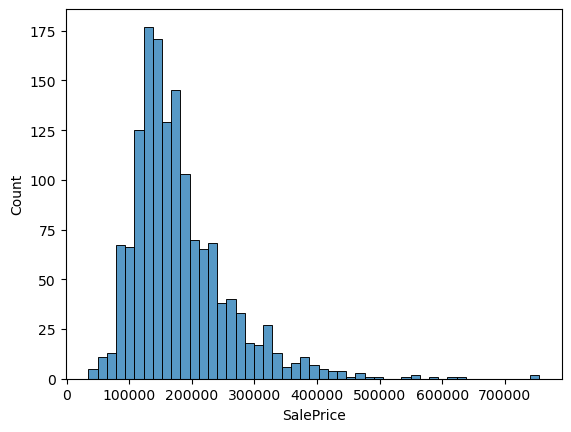

In [10]:
sns.histplot(y_train)

# Enconding of categoricals

## ordinal enconding, hard-coded
for e.g. quality ratings (Excellent, Good, Fair, Poor, ...) and etc...

In [11]:
categorical_ft = [] # list to collect the name of categorical features (discontiuous features both ordinal ratings and boolean features)

In [12]:
#ordinal enconding, hard-coded for e.g. quality categories (Excellent, Good, Fair, Poor, etc...)
ord_ft = {
    'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3,'IR3': 4},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'ExterQual': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'Po': 5},
    'ExterCond': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'Po': 5},
    'BsmtQual': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'Po': 5,'NA': 6}, 
    'BsmtCond': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'Po': 5,'NA': 6},
    'BsmtExposure': {'Gd': 1, 'Av': 2, 'Mn': 3, 'No': 4,'NA': 5},
    'BsmtFinType1': {'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4,'LwQ': 5,'Unf': 6,'NA': 7},
    'BsmtFinType2': {'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4,'LwQ': 5,'Unf': 6,'NA': 7},
    'HeatingQC': {'Ex': 1, 'Gd': 2, 'TA': 3,'Fa': 4, 'Po': 5},
    'Electrical': {'SBrkr': 1, 'FuseA': 2, 'FuseF': 3, 'FuseP': 4,'Mix': 5},
    'KitchenQual': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'Po': 5},
    'Functional': {'Typ': 1, 'Min1': 2, 'Min2': 3, 'Mod': 4,'Maj1': 5,'Maj2': 6,'Sev': 7,'Sal': 8},
    'FireplaceQu': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'Po': 5,'NA': 6},
    'GarageFinish': {'Fin': 1, 'RFn': 2, 'Unf': 3, 'NA': 4},
    'GarageQual': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'Po': 5,'NA': 6},
    'GarageCond': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'Po': 5,'NA': 6},
    'PavedDrive': {'Y': 1, 'P': 2, 'N': 3},
    'PoolQC': {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4,'NA': 5},
    'Fence': {'GdPrv': 1, 'MnPrv': 2, 'GdWo': 3, 'MnWw': 4, 'NA': 5},
    'SaleCondition': {'Normal': 1, 'Abnorml': 2, 'AdjLand': 3, 'Alloca': 4, 'Family': 5, 'Partial': 6},
}

train[list(ord_ft)] = train[list(ord_ft)].fillna('NA')
test[list(ord_ft)] = test[list(ord_ft)].fillna('NA')

train.replace(ord_ft, inplace=True)
test.replace(ord_ft, inplace=True)

train.replace('NA', np.nan, inplace=True)
test.replace('NA', np.nan, inplace=True)

/tmp/ipykernel_196916/1488741958.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.replace(ord_ft, inplace=True)
/tmp/ipykernel_196916/1488741958.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.replace(ord_ft, inplace=True)
/tmp/ipykernel_196916/1488741958.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silen

In [13]:
# new column for Basement Yes/No?
train['Bsmt'] = train['BsmtCond'].isna().astype(int)
test['Bsmt'] = test['BsmtCond'].isna().astype(int)

# new column for Garage Yes/No?
train['Garage'] = train['GarageFinish'].isna().astype(int)
test['Garage'] = test['GarageFinish'].isna().astype(int)


In [14]:
# unfolds the 'MiscFeature' into separate columns and drops it, keeps the misc feature name to add to ccategorical_ft list 
misc_names = []
for misc_feat in train['MiscFeature'].dropna().unique():
    train[misc_feat] = (train['MiscFeature'] == misc_feat).astype(int)
    test[misc_feat] = (test['MiscFeature'] == misc_feat).astype(int)
    misc_names.append(misc_feat)

train.drop(columns='MiscFeature', inplace=True)
test.drop(columns='MiscFeature', inplace=True)    


In [15]:
categorical_ft.extend(ord_ft.keys())
categorical_ft.extend(['Bsmt', 'Garage'])
categorical_ft.extend(misc_names)

In [16]:
print('# of obj columns:', train.select_dtypes(include='O').columns.size) 
print('# of num columns:', train.select_dtypes(exclude='O').columns.size) 

# of obj columns: 21
# of num columns: 63


## label encoding
for non-inteligible, unknown features that can't be transformed to an ordered qualitative sequence

In [17]:
train_cat = train.select_dtypes(include='O')
test_cat = test.select_dtypes(include='O')
train_cat

,MSZoning,Street,Alley,LandContour,Utilities,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,SaleType
0,RL,Pave,NaN,Lvl,AllPub,Inside,CollgCr,Norm,Norm,1Fam,...,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,WD
1,RL,Pave,NaN,Lvl,AllPub,FR2,Veenker,Feedr,Norm,1Fam,...,Gable,CompShg,MetalSd,MetalSd,NaN,CBlock,GasA,Y,Attchd,WD
2,RL,Pave,NaN,Lvl,AllPub,Inside,CollgCr,Norm,Norm,1Fam,...,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,WD
3,RL,Pave,NaN,Lvl,AllPub,Corner,Crawfor,Norm,Norm,1Fam,...,Gable,CompShg,Wd Sdng,Wd Shng,NaN,BrkTil,GasA,Y,Detchd,WD
4,RL,Pave,NaN,Lvl,AllPub,FR2,NoRidge,Norm,Norm,1Fam,...,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Lvl,AllPub,Inside,Gilbert,Norm,Norm,1Fam,...,Gable,CompShg,VinylSd,VinylSd,NaN,PConc,GasA,Y,Attchd,WD
1456,RL,Pave,NaN,Lvl,AllPub,Inside,NWAmes,Norm,Norm,1Fam,...,Gable,CompShg,Plywood,Plywood,Stone,CBlock,GasA,Y,Attchd,WD
1457,RL,Pave,NaN,Lvl,AllPub,Inside,Crawfor,Norm,Norm,1Fam,...,Gable,CompShg,CemntBd,CmentBd,NaN,Stone,GasA,Y,Attchd,WD
1458,RL,Pave,NaN,Lvl,AllPub,Inside,NAmes,Norm,Norm,1Fam,...,Hip,CompShg,MetalSd,MetalSd,NaN,CBlock,GasA,Y,Attchd,WD


In [18]:
d = defaultdict(LabelEncoder) # structure to add the label encoders for each categorical feature (df column)

# Encoding the variable
train_cat_enc = train_cat.apply(lambda x: d[x.name].fit_transform(x))
test_cat_enc = test_cat.apply(lambda x: d[x.name].fit_transform(x))
train_cat_enc

# Inverse the encoded
#train_cat_enc.apply(lambda x: d[x.name].inverse_transform(x))
#test_cat_enc.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
#new_data.apply(lambda x: d[x.name].transform(x))

,MSZoning,Street,Alley,LandContour,Utilities,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,SaleType
0,3,1,2,3,0,4,5,2,2,0,...,1,1,12,13,1,2,1,1,1,8
1,3,1,2,3,0,2,24,1,2,0,...,1,1,8,8,3,1,1,1,1,8
2,3,1,2,3,0,4,5,2,2,0,...,1,1,12,13,1,2,1,1,1,8
3,3,1,2,3,0,0,6,2,2,0,...,1,1,13,15,3,0,1,1,5,8
4,3,1,2,3,0,2,15,2,2,0,...,1,1,12,13,1,2,1,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,1,2,3,0,4,8,2,2,0,...,1,1,12,13,3,2,1,1,1,8
1456,3,1,2,3,0,4,14,2,2,0,...,1,1,9,10,2,1,1,1,1,8
1457,3,1,2,3,0,4,6,2,2,0,...,1,1,5,5,3,4,1,1,1,8
1458,3,1,2,3,0,4,12,2,2,0,...,3,1,8,8,3,1,1,1,1,8


In [19]:
train_clean = pd.concat([train.select_dtypes(exclude='O'), train_cat_enc], axis=1)
test_clean = pd.concat([test.select_dtypes(exclude='O'), test_cat_enc], axis=1)

In [20]:
train_clean.select_dtypes(include=float)

,LotFrontage,MasVnrArea,Electrical,GarageYrBlt
0,65.0,196.0,1.0,2003.0
1,80.0,0.0,1.0,1976.0
2,68.0,162.0,1.0,2001.0
3,60.0,0.0,1.0,1998.0
4,84.0,350.0,1.0,2000.0
...,...,...,...,...
1455,62.0,0.0,1.0,1999.0
1456,85.0,119.0,1.0,1978.0
1457,66.0,0.0,1.0,1941.0
1458,68.0,0.0,2.0,1950.0


# Impute of missing values NaN

In [21]:
train_clean.isna().sum().sort_values(ascending=False)[:10]/train.shape[0]

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
MoSold         0.000000
Othr           0.000000
Gar2           0.000000
Shed           0.000000
Garage         0.000000
Bsmt           0.000000
dtype: float64

In [22]:
test_clean.isna().sum().sort_values(ascending=False)[:10]/train.shape[0]

LotFrontage     0.155479
GarageYrBlt     0.053425
MasVnrArea      0.010274
BsmtHalfBath    0.001370
Functional      0.001370
BsmtFullBath    0.001370
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
GarageCars      0.000685
dtype: float64

In [23]:
impute_cols_train = train_clean.columns[train_clean.isna().any()]
impute_cols_test = test_clean.columns[test_clean.isna().any()]

print(impute_cols_test)
print(impute_cols_train)

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageYrBlt', 'GarageCars', 'GarageArea'],
      dtype='object')
Index(['LotFrontage', 'MasVnrArea', 'Electrical', 'GarageYrBlt'], dtype='object')


In [24]:
imputer = KNNImputer(n_neighbors=20, weights='distance')
train_imp = pd.DataFrame(data=imputer.fit_transform(train_clean), index=train_clean.index, columns=train_clean.columns)
train_clean = train_imp
test_imp = pd.DataFrame(data=imputer.fit_transform(test_clean), index=test_clean.index, columns=test_clean.columns)
test_clean = train_imp

In [25]:
train_clean.isna().any(axis=None)

False

In [26]:
test_clean.isna().any(axis=None)

False

# Feature scaling

In [27]:
# standard scaling 

In [28]:
scaler = StandardScaler()
scaler.fit(train_clean);

In [29]:
X_train = pd.DataFrame(scaler.transform(train_clean), index=train_clean.index, columns=train_clean.columns)
X_test = pd.DataFrame(scaler.transform(test_clean), index=test_clean.index, columns=test_clean.columns)

# Interaction generation & selection

In [30]:
print('Dimensions')
print('{}\t\t{}'.format('X_train', X_train.shape))
print('{}\t\t{}'.format('X_test', X_train.shape))
print('{}\t{}'.format('categorical_ft', len(categorical_ft)))

Dimensions
X_train		(1460, 84)
X_test		(1460, 84)
categorical_ft	27


In [31]:
X_train, categorical_ft = interactions_gen(X_train, categorical_ft)

In [32]:
X_train, categorical_ft = interaction_selection(X_train, categorical_ft, y_train)

In [33]:
print('Dimensions')
print('{}\t\t{}'.format('X_train', X_train.shape))
print('{}\t\t{}'.format('X_test', X_train.shape))
print('{}\t{}'.format('categorical_ft', len(categorical_ft)))

Dimensions
X_train		(1460, 3211)
X_test		(1460, 3211)
categorical_ft	303


In [34]:
X_test, _ = interactions_gen(X_test, categorical_ft)

In [35]:
X_test = X_test[X_train.columns]

In [36]:
print('Dimensions')
print('{}\t\t{}'.format('X_train', X_train.shape))
print('{}\t\t{}'.format('X_test', X_train.shape))
print('{}\t{}'.format('categorical_ft', len(categorical_ft)))

Dimensions
X_train		(1460, 3211)
X_test		(1460, 3211)
categorical_ft	303


# Multi Linear Regression

In [40]:
X_train.columns[83]

'MSSubClassxBsmtUnfSF'

## Sandbox

# Notes

- [x] Feature engineering
    - [x] categorical encoding
    - [x] imputation
    - [x] feature scaling
    - [x] interaction (2nd deg.)
        - [ ] fix the the interaction_selection() because some of the original (linear) features are being removed  

- [ ] Models
    - [ ] add multi linear regression
    - [ ] use GridSearchCV for {Lasso, Rigde} {??? 1e-3, ..., 1e+3 ???}
    - [ ] principal componant regression
    - [ ] ARD regression
    - [ ] Bayesian regression
    - [ ] ANN

### Misc
- [x] add type hints/annotations to functions and code boundaries
